In [1]:
from huggingface_hub import repo_info, login
from huggingface_hub.utils import RepositoryNotFoundError
import json
api_key_path = "../../api_keys.json"

with open(api_key_path, 'r') as j:
    login_key = json.loads(j.read())['hf-llama']

login(login_key)

#- Scientific programming
import numpy as np
import pandas as pd
from tqdm import tqdm

#- Transformers & Datasets
from datasets import Dataset, DatasetDict
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from peft import get_peft_model, LoraConfig, PeftModel
import torch

#- Processing
import pickle
import datetime
import os
import gc


def repo_exists(repo_id, token=None):
    try:
        repo_info(repo_id, token=token)
        return True
    except RepositoryNotFoundError:
        return False

df = pickle.load(open('/home/paperspace/2024-06-10-tweets-with-text.p', 'rb'))
unique_standardized_names, n_tweets_per_name = np.unique(df['name_standardized'].values, return_counts=True)

skip_list = ['jacky_rosen', 'dean_phillips', 'dan_sullivan', 'alexandria_ocasio-cortez', 'van_duyne,', 'pascrell_jr.,', "beto_o'rourke"]
df.head()

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/paperspace/.cache/huggingface/token
Login successful


,name,party,twitter_lower,years,chamber,state,postedAt,source,tweetId,name_standardized,text
0,Josh Gottheimer D-NJ,D,repjoshg,2021_2022,House,NJ,2022-05-29 13:22:24.171,PolitWoops,1530902377196314624,josh_gottheimer,Thanks to the Bipartisan Infrastructure Bill t...
1,Ed Markey D-MA,D,senmarkey,2011_2012,Senate,MA,2011-05-13 21:06:26.255,PolitWoops,69146505528868864,ed_markey,"Since COPPA in 98, kids more likely 2 be poked..."
2,Debbie Stabenow D-MI,D,senstabenow,2021_2022,Senate,MI,2022-03-02 01:14:27.293,PolitWoops,1498829050919411712,debbie_stabenow,My virtual guest at the State of the Union wil...
3,Ted Cruz R-TX,R,sentedcruz,2019_2020,Senate,TX,2019-10-31 16:48:33.055,PolitWoops,1189947274526384128,ted_cruz,.@tedcruz offering rare praise for Facebook on...
4,Dan Bishop R-NC,R,repdanbishop,2021_2022,House,NC,2021-08-25 00:15:49.917,PolitWoops,1430322991376834560,dan_bishop,


In [2]:
def get_lora_matrices(model, target_modules = ["k_proj","o_proj","q_proj","v_proj"]):
    layers = model._modules['base_model']._modules['model']._modules['model']._modules['layers']

    lora_matrices = []

    for ell in layers:
        attention_layers = ell._modules['self_attn']
        for target_module in target_modules:
            target = attention_layers._modules[target_module]._modules
            lora_A=target['lora_A']._modules['default'].weight.data
            lora_B=target['lora_B']._modules['default'].weight.data

            lora_matrices.append(lora_A)
            lora_matrices.append(lora_B)

    return lora_matrices

In [3]:
valid_names=[]
invalid_names=[]
valid_path_dict = {}


for name in unique_standardized_names:
    if '.' in name or ',' in name:
        if name not in skip_list:
            skip_list.append(name)
    
    if name in skip_list:
        print(f'{name} in skip list, skipping.')
        continue

    if 'Senate' not in df[df['name_standardized'] == name]['chamber'].values:
        continue

        
    if '2021_2022' not in df[df['name_standardized'] == name]['years'].values:
        continue

    print(f'{name} was in senate 2021-2022')

    hub_path = 'nomic-ai/' + name
    hub_path = hub_path.replace("'", "")
    if repo_exists(hub_path):
        valid_names.append(name)
        valid_path_dict[name] = hub_path 
    else:
        invalid_names.append(name)

a._ferguson in skip list, skipping.
alex_padilla was in senate 2021-2022
alexandria_ocasio-cortez in skip list, skipping.
angus_king was in senate 2021-2022
ben_cardin was in senate 2021-2022
bernard_sanders was in senate 2021-2022
beto_o'rourke in skip list, skipping.
bill_cassidy was in senate 2021-2022
bill_hagerty was in senate 2021-2022
bishop_jr., in skip list, skipping.
blunt_rochester, in skip list, skipping.
brian_schatz was in senate 2021-2022
c._franklin in skip list, skipping.
c._ruppersberger in skip list, skipping.
catherine_masto was in senate 2021-2022
chuck_schumer was in senate 2021-2022
cindy_hyde-smith was in senate 2021-2022
cortez_masto, in skip list, skipping.
cory_booker was in senate 2021-2022
cynthia_lummis was in senate 2021-2022
dan_sullivan in skip list, skipping.
dean_phillips in skip list, skipping.
deb_fischer was in senate 2021-2022
debbie_stabenow was in senate 2021-2022
dianne_feinstein was in senate 2021-2022
dick_durbin was in senate 2021-2022
e.b._

In [6]:
print(len(invalid_names), invalid_names)

36 ['dick_durbin', 'elizabeth_warren', 'gary_peters', 'jack_reed', 'james_lankford', 'jeff_merkley', 'john_barrasso', 'john_hoeven', 'jon_tester', 'joseph_manchin', 'josh_hawley', 'maria_cantwell', 'markwayne_mullin', 'michael_bennet', 'mike_braun', 'mike_lee', 'mitch_mcconnell', 'pat_toomey', 'patrick_leahy', 'richard_blumenthal', 'rick_scott', 'robert_casey', 'robert_menendez', 'roger_wicker', 'ron_johnson', 'sheldon_whitehouse', 'sherrod_brown', 'susan_collins', 'tammy_baldwin', 'tammy_duckworth', 'ted_budd', 'thom_tillis', 'tim_scott', 'tina_smith', 'tom_carper', 'tom_cotton']


In [7]:
model_str = 'meta-llama/Meta-Llama-3-8B-Instruct'

tokenizer = AutoTokenizer.from_pretrained(model_str)
special_tokens_dict = {'additional_special_tokens': ['[link]']}
tokenizer.add_special_tokens(special_tokens_dict)

base_model = AutoModelForCausalLM.from_pretrained(model_str, device_map='cpu')
base_model.resize_token_embeddings(len(tokenizer))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Embedding(128257, 4096)

In [8]:
from itertools import combinations
from shutil import rmtree

save_path = '/home/paperspace/congressional-twin/models/lora_matrices_differences_dict.p'
if os.path.exists(save_path):
    differences_dict = pickle.load(open(save_path, 'rb'))
else:
    differences_dict={}

if os.path.exists('downloaded_model_list.p'):
    downloaded_model_list = pickle.load(open('downloaded_model_list.p', 'rb'))
else:
    downloaded_model_list=[]
    
for name in valid_names:
    if name not in differences_dict:
        differences_dict[name] = {}

iterable = combinations(valid_names, 2)
max_downloaded_models=30
added_list=[]

for (name1, name2) in iterable:
    #- If pair has already been done, move on.
    if name2 in differences_dict[name1]:
        continue

    #- Get difference of LoRA matrices
    hub_path1 = valid_path_dict[name1]
    model = PeftModel.from_pretrained(base_model, hub_path1, device_map='cpu')
    lora_matrices1 = get_lora_matrices(model)

    hub_path2 = valid_path_dict[name2]
    model = PeftModel.from_pretrained(base_model, hub_path2, device_map='cpu')
    lora_matrices2 = get_lora_matrices(model)

    temp_diff = 0
    for ii, matrix in enumerate(lora_matrices1):
        temp_diff += np.linalg.norm(matrix - lora_matrices2[ii])**2
    temp_diff = np.sqrt(temp_diff)

    #- Add difference to differences_dict
    differences_dict[name1][name2] = temp_diff
    differences_dict[name2][name1] = temp_diff

    added_list.append((name1, name2))

    pickle.dump(differences_dict, open(save_path, 'wb'))

    #- Add names to downlaoded models if not already there
    if name1 not in downloaded_model_list:
        downloaded_model_list.append(name1)

    if name2 not in downloaded_model_list:
        downloaded_model_list.append(name2)

    #- If disk space is low, get all combinations of already downloaded models
    if len(downloaded_model_list) >= max_downloaded_models:
        downloaded_iterable = combinations(downloaded_model_list, 2)

        for (name1, name2) in downloaded_iterable:
            if name2 in differences_dict[name1]:
                continue
            if name1 not in valid_names or name2 not in valid_names:
                continue

            hub_path1 = valid_path_dict[name1]
            model = PeftModel.from_pretrained(base_model, hub_path1, device_map='cpu')
            lora_matrices1 = get_lora_matrices(model)
        
            hub_path2 = valid_path_dict[name2]
            model = PeftModel.from_pretrained(base_model, hub_path2, device_map='cpu')
            lora_matrices2 = get_lora_matrices(model)

            temp_diff = 0
            for ii, matrix in enumerate(lora_matrices1):
                temp_diff += np.linalg.norm(matrix - lora_matrices2[ii])**2
            temp_diff = np.sqrt(temp_diff)

            differences_dict[name1][name2] = temp_diff
            differences_dict[name2][name1] = temp_diff

            added_list.append((name1, name2))

            pickle.dump(differences_dict, open(save_path, 'wb'))

        print(f'removing {downloaded_model_list}')
        for _name in downloaded_model_list:
            tmp = f'models--nomic-ai--{_name}'
            rmtree(f'/home/paperspace/.cache/huggingface/hub/{tmp}')

        print(added_list)
        downloaded_model_list = []
        added_list = []
    pickle.dump(downloaded_model_list, open('downloaded_model_list.p', 'wb'))

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

removing ['alex_padilla', 'angus_king', 'ben_cardin', 'bernard_sanders', 'bill_cassidy', 'bill_hagerty', 'catherine_masto', 'chuck_schumer', 'cory_booker', 'deb_fischer', 'dianne_feinstein', 'brian_schatz', 'cindy_hyde-smith', 'cynthia_lummis', 'debbie_stabenow', 'ed_markey', 'jeanne_shaheen', 'jim_risch', 'john_hickenlooper', 'john_kennedy', 'john_thune', 'jon_ossoff', 'kevin_cramer', 'maggie_hassan', 'mark_kelly', 'mitt_romney', 'raphael_warnock', 'richard_shelby', 'rob_portman', 'shelley_capito']
[('alex_padilla', 'angus_king'), ('alex_padilla', 'ben_cardin'), ('alex_padilla', 'bernard_sanders'), ('alex_padilla', 'bill_cassidy'), ('alex_padilla', 'bill_hagerty'), ('alex_padilla', 'catherine_masto'), ('alex_padilla', 'chuck_schumer'), ('alex_padilla', 'cory_booker'), ('alex_padilla', 'deb_fischer'), ('alex_padilla', 'dianne_feinstein'), ('angus_king', 'ben_cardin'), ('angus_king', 'bernard_sanders'), ('angus_king', 'bill_cassidy'), ('angus_king', 'bill_hagerty'), ('angus_king', 'bria

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

In [9]:
party_dict = {}
for name in valid_names:
    party = df[df['name_standardized'] == name]['party'].values[0].lower()
    party_dict[name] = party

33
29


<Axes: >

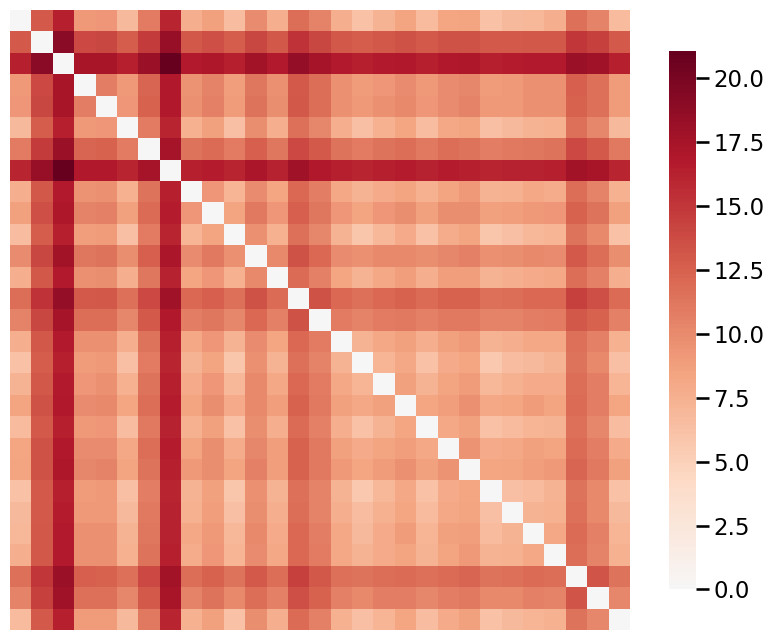

In [13]:
from graspologic.plot import heatmap

print(len(valid_names))
_D_names = []
for name in valid_names:
    temp = np.mean(list(differences_dict[name].values()))
    if temp < 25:
        _D_names.append(name)

print(len(_D_names))
D = np.zeros((len(_D_names), len(_D_names)))
for i, name1 in enumerate(_D_names):
    for j, name2 in enumerate(_D_names[i+1:], i+1):
        D[i,j] = differences_dict[name1][name2]
        D[j,i] = differences_dict[name2][name1]

heatmap(D)

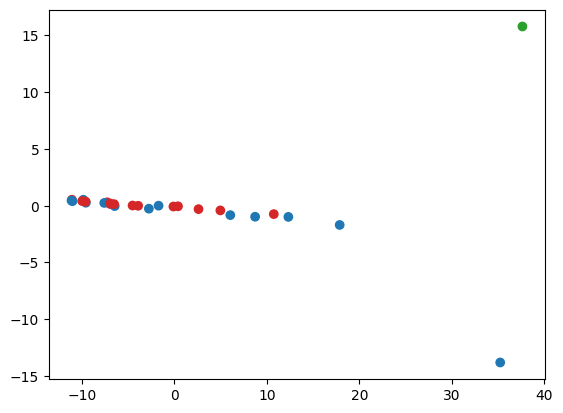

In [14]:
from graspologic.embed import ClassicalMDS
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
cmds = ClassicalMDS()
cmds_embds=cmds.fit_transform(D)

color_dict = {'r': 'tab:red', 'd': 'tab:blue', 'i': 'tab:green'}

ax.scatter(cmds_embds[:, 0], cmds_embds[:, 1], c=[color_dict[p] for name, p in party_dict.items() if name in _D_names])

In [50]:
_valid_hub_paths = valid_hub_paths
n_models = len(_valid_hub_paths)
D = np.zeros((n_models, n_models))

for i, hub_path1 in enumerate(_valid_hub_paths):
    model = PeftModel.from_pretrained(base_model, hub_path1, device_map='cpu')
    lora_matrices1 = get_lora_matrices(model)

    print(hub_path1)

    del model

    for j, hub_path2 in enumerate(_valid_hub_paths[i+1:], i+1):
        print(hub_path2)
        model = PeftModel.from_pretrained(base_model, hub_path2, device_map='cpu')
        lora_matrices2 = get_lora_matrices(model)

        temp_diff = 0
        for ii, matrix in enumerate(lora_matrices1):
            temp_diff += np.linalg.norm(matrix - lora_matrices2[ii])**2
        temp_diff = np.sqrt(temp_diff)

        D[i,j] = temp_diff
        D[j,i] = temp_diff

        del model
    

nomic-ai/joni_ernst
nomic-ai/garret_graves
nomic-ai/lee_zeldin
nomic-ai/carlos_curbelo
nomic-ai/mike_enzi
nomic-ai/don_young
nomic-ai/madeleine_dean
nomic-ai/jim_risch
nomic-ai/josh_harder
nomic-ai/richard_neal
nomic-ai/peter_defazio
nomic-ai/anna_eshoo
nomic-ai/david_scott
nomic-ai/cory_gardner
nomic-ai/kurt_schrader
nomic-ai/scott_rigell
nomic-ai/lizzie_fletcher
nomic-ai/scott_tipton
nomic-ai/michael_waltz
nomic-ai/donald_mceachin
nomic-ai/ralph_norman


adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

nomic-ai/andy_kim


adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

nomic-ai/kay_granger


adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

nomic-ai/lauren_underwood


adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

nomic-ai/barbara_mikulski


adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

nomic-ai/hal_rogers


adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

nomic-ai/juan_vargas


adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

nomic-ai/mike_gallagher


adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

nomic-ai/katie_porter


adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

nomic-ai/brian_babin


adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

nomic-ai/garret_graves
nomic-ai/lee_zeldin
nomic-ai/carlos_curbelo
nomic-ai/mike_enzi
nomic-ai/don_young
nomic-ai/madeleine_dean
nomic-ai/jim_risch
nomic-ai/josh_harder
nomic-ai/richard_neal
nomic-ai/peter_defazio
nomic-ai/anna_eshoo
nomic-ai/david_scott
nomic-ai/cory_gardner
nomic-ai/kurt_schrader
nomic-ai/scott_rigell
nomic-ai/lizzie_fletcher
nomic-ai/scott_tipton
nomic-ai/michael_waltz
nomic-ai/donald_mceachin
nomic-ai/ralph_norman
nomic-ai/andy_kim
nomic-ai/kay_granger
nomic-ai/lauren_underwood
nomic-ai/barbara_mikulski
nomic-ai/hal_rogers
nomic-ai/juan_vargas
nomic-ai/mike_gallagher
nomic-ai/katie_porter
nomic-ai/brian_babin
nomic-ai/lee_zeldin
nomic-ai/carlos_curbelo
nomic-ai/mike_enzi
nomic-ai/don_young
nomic-ai/madeleine_dean
nomic-ai/jim_risch
nomic-ai/josh_harder
nomic-ai/richard_neal
nomic-ai/peter_defazio
nomic-ai/anna_eshoo
nomic-ai/david_scott
nomic-ai/cory_gardner
nomic-ai/kurt_schrader
nomic-ai/scott_rigell
nomic-ai/lizzie_fletcher
nomic-ai/scott_tipton
nomic-ai/michael

In [53]:
party_dict = {}
for name in valid_names:
    party = df[df['name_standardized'] == name]['party'].values[0].lower()
    party_dict[name] = party

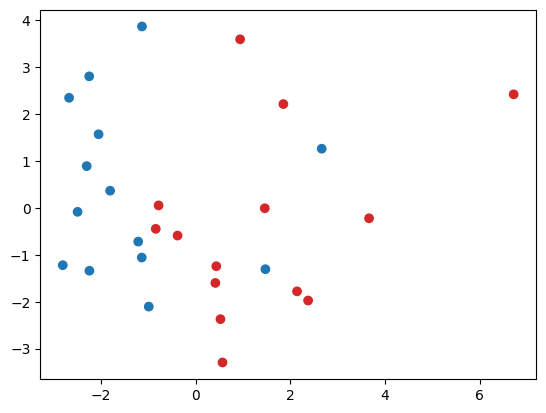

In [68]:
from graspologic.embed import ClassicalMDS
import matplotlib.pyplot as plt

inds = np.arange(30)[D[1]<15]

temp_party_list = []
for hub_path in _valid_hub_paths:
    name = hub_path.split('/')[1]
    temp_party_list.append(party_dict[name])
temp_party_list=np.array(temp_party_list)

color_dict={'r': 'tab:red', 'd': 'tab:blue', 'i': 'tab:green'}
cmds = ClassicalMDS()
cmds_embds=cmds.fit_transform(D[np.ix_(inds, inds)])
fig, ax= plt.subplots(1,1)
ax.scatter(cmds_embds[:, 0], cmds_embds[:,1], color=[color_dict[p] for p in temp_party_list[inds]])

In [67]:
D[np.ix_(np.arange(30)[D[1]<15], np.arange(30)[D[1]<15])].shape

(28, 28)

In [31]:
D[1:, 1:].shape

(19, 19)

In [14]:
hub_path1, hub_path2

('nomic-ai/richard_neal', 'nomic-ai/richard_neal')

<Axes: >

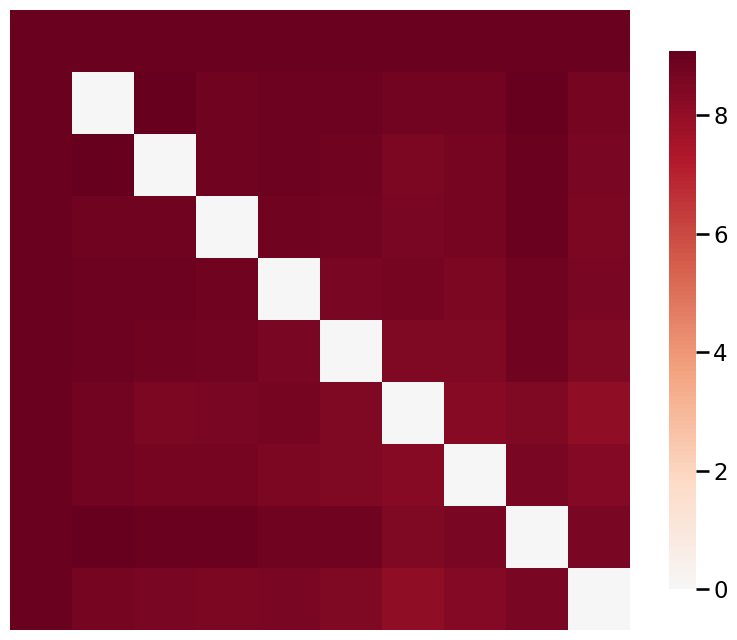

In [24]:
from graspologic.plot import heatmap
heatmap(D)

In [14]:
def get_lora_matrices(model, target_modules = ["k_proj","o_proj","q_proj","v_proj"]):
    layers = model._modules['base_model']._modules['model']._modules['model']._modules['layers']

    lora_matrices = []

    for ell in layers:
        attention_layers = ell._modules['self_attn']
        for target_module in target_modules:
            target = attention_layers._modules[target_module]._modules
            lora_A=target['lora_A']._modules['default'].weight.data
            lora_B=target['lora_B']._modules['default'].weight.data

            lora_matrices.append(lora_A)
            lora_matrices.append(lora_B)

    return lora_matrices

In [16]:
lora_matrices = get_lora_matrices(model)
lora_matrices[0]

tensor([[-0.0144, -0.0002, -0.0122,  ...,  0.0063, -0.0044,  0.0067],
        [ 0.0148,  0.0105,  0.0094,  ...,  0.0034, -0.0138,  0.0085],
        [ 0.0065,  0.0073,  0.0151,  ..., -0.0064, -0.0057, -0.0069],
        ...,
        [-0.0057, -0.0082, -0.0140,  ...,  0.0129,  0.0078, -0.0089],
        [-0.0036,  0.0149, -0.0064,  ...,  0.0075, -0.0166, -0.0124],
        [-0.0110, -0.0107, -0.0063,  ...,  0.0124,  0.0078, -0.0014]])

In [52]:
layers = model._modules['base_model']._modules['model']._modules['model']._modules['layers']

In [46]:
len(model._modules['base_model']._modules['model']._modules['model']._modules['layers']

32

In [44]:
model._modules['base_model']._modules['model']._modules['model']._modules['layers'][0]._modules['self_attn']._modules['q_proj']._modules['lora_A']._modules['default'].weight

torch.Size([64, 4096])